# Sensor Post Selection
## This notebook is for creating all data and figures related to sensor post selection (SPS)
### Final graphs should look something like:
![title](images/SPSFid.png)
![title](images/SPSli.png)
![title](images/SPSdist.png)



In [2]:
from qutip import *
from qiskit import *
import numpy as np
import sympy as sp
import scipy
from simulators.Utils import bin2num, printQC
from simulators.BigStepSimulation import EfficientQuantumRegister
from simulators.SmallStepSimulation import InCoherentQuantumRegister
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from simulators.Utils import showQubits
import os
import time

hi


In [3]:
### utils for the notebook ###

e='1'
initial_state_for_NoisyRegister = tensor([fock_dm(2,0), fock_dm(2,int(e))])
initial_state_for_PerfectRegister = tensor([basis(2,0),basis(2,int(e))])
# parameters for noisy simulators
Tgate = 1
dt = Tgate/20
T1_usual_qubit = 1e4*Tgate # just a random value
T2_usual_qubit = 1e4*Tgate # just a random value
T1_sensor_qubit = 1e10*T1_usual_qubit # sensor qubit effectively does not decohere
T2_sensor_qubit = 1e10*T2_usual_qubit # sensor qubit effectively does not decohere
T1s = [T1_usual_qubit,T1_usual_qubit,T1_usual_qubit,T1_usual_qubit,T1_usual_qubit,T1_usual_qubit,T1_usual_qubit,T1_sensor_qubit]
T2s = [T2_usual_qubit,T2_usual_qubit,T2_usual_qubit,T2_usual_qubit,T2_usual_qubit,T2_usual_qubit,T2_usual_qubit,T2_sensor_qubit]

num_points = 25
num_angles = 10
num_k = 8

def applyOperator(reg,noisy,Operator):
    """
    applies operator on register
    :param reg: quantum register
    :param noisy: boolean - True for noisy register
    :param Operator: the operator to apply
    :return: None
    """
    if not noisy:
        reg.state = Operator*reg.state # apply permutation
    else:
        reg.state = Operator*reg.state*Operator.dag() # apply permutation

def num2bin(angle, percision):
    """
    :param angle: number between 0 and 1
    :param percision: number of digits in result
    :return: the string for binary fraction for num
    """
    basis=[2**-(i+1) for i in range(percision)]
    result='0.'
    for i in basis:
        if i<=angle:
            result += '1'
            angle-=i
        else:
            result +='0'
    return result[2:]

def Kitaev_for_simpleRegister_SPS(SPS=None,k1=1, noisy=False, reg_params = None, phi = 1/8, dephase=True, amp_damp = False):
    """
    this function creates a noisy or perfect 2-qubit quantum register and runs IQPE on it.
     prints probabilities in each stage and the final measurements results.
    :param PS: boolean, if True: put Post Selection in the run
    :param noisy: boolean, if True: run with noisy register
    :param reg_params: list of (T1,T2,T1s,T2s,dt,Tgate) if noisy==True
    :param phi: such that 2*pi*phi is the eigenphase
    :param percision: number of digits
    :return: None
    """

    Ps = []
    PsK = []

    if noisy:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(2,initial_state_for_NoisyRegister,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        registerK = InCoherentQuantumRegister(2,initial_state_for_NoisyRegister,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        # register.collect = True
        # register.collect_bloch = True
        register.setError(dephase=dephase,amplitude_damp=amp_damp)
        registerK.setError(dephase=dephase,amplitude_damp=amp_damp)
    else:
        register = EfficientQuantumRegister(2,initial_state_for_PerfectRegister)
        registerK = EfficientQuantumRegister(2,initial_state_for_PerfectRegister)

    command = [[('H',0,None,None)]]
    digit = register.run(command)
    digit = registerK.run(command)


    command = [[('Rz',0,None,np.pi/2)]]
    digit = registerK.run(command)

    if ((SPS=='single') or (SPS is None)):

        for i in range(int(2**(k1-1))):
            command = [[('Rz',1,None,2*np.pi*phi/4)]]
            digit = register.run(command)
            digit = registerK.run(command)

        command = [[('CNOT',1,0,None)]]
        digit = register.run(command)
        digit = registerK.run(command)

        for i in range(int(2**(k1-1))):
            command = [[('Rz',1,None,-2*np.pi*phi/2)]]
            digit = register.run(command)
            digit = registerK.run(command)

        command = [[('CNOT',1,0,None)]]
        digit = register.run(command)
        digit = registerK.run(command)

        for i in range(int(2**(k1-1))):
            command = [[('Rz',1,None,2*np.pi*phi/4)]]
            digit = register.run(command)
            digit = registerK.run(command)

        if SPS=='single':
            # post selection
            command = [[('SingleQubitOperator',1,None,basis(2,int(e))*basis(2,int(e)).dag())]]
            digit = register.run(command)
            digit = registerK.run(command)


    else: # SPS=='multiple':

        for i in range(int(2**(k1-1))):

            command = [[('Rz',1,None,2*np.pi*phi/4)]]
            digit = register.run(command)
            digit = registerK.run(command)

            command = [[('CNOT',1,0,None)]]
            digit = register.run(command)
            digit = registerK.run(command)

            command = [[('Rz',1,None,-2*np.pi*phi/2)]]
            digit = register.run(command)
            digit = registerK.run(command)

            command = [[('CNOT',1,0,None)]]
            digit = register.run(command)
            digit = registerK.run(command)

            command = [[('Rz',1,None,2*np.pi*phi/4)]]
            digit = register.run(command)
            digit = registerK.run(command)

            command = [[('SingleQubitOperator',1,None,basis(2,int(e))*basis(2,int(e)).dag())]]
            digit = register.run(command)
            digit = registerK.run(command)

            Ps.append(register.state.tr())
            PsK.append(registerK.state.tr())

            register.state = register.state/register.state.tr()
            registerK.state = registerK.state/registerK.state.tr()


    command = [[('H',0,None,None)]]
    digit = register.run(command)
    digit = registerK.run(command)
    # print(registerK.state)

    if ((SPS=='single') or (SPS is None)):
        return register.state, register.state.tr(), registerK.state, registerK.state.tr()
    else:
        return register.state, Ps, registerK.state, PsK

def mainSPS(num_points, num_angles, num_k, alg, fold='SPS_T1'):
    """
    :param num_points: number of different T2 or T1 for the ancilla qubit
    :param num_angles: number of angles to average over
    :param num_k: maximal k where we apply U^2^k
    :param alg: 'singleSPS', 'multipleSPS' or 'NoSPS'.
    :param fold: data is created in folder 'data\\averageing_fidelity\\Kitaev\\' + fold.
    :return: None
    """
    path = os.getcwd()
    Tgate = 1
    dt = Tgate/20
    reg_params = (1,1,[1,1],[1,1],dt,Tgate)
    T2_list = np.geomspace(Tgate*10, Tgate*1000, num_points, endpoint=False)
    T1_list = np.geomspace(Tgate*10, Tgate*1000, num_points, endpoint=False)
    k_list = [i+1 for i in range(num_k)]
    power = 0
    phi_list = np.linspace(0,1,num_angles,endpoint=False)

    folder = os.path.join(path, 'data\\averageing_fidelity\\Kitaev\\'+fold)
    try:
        os.makedirs(folder)
    except:
        pass
    try:
        for phi in phi_list:
            ideal, trash, idealK, trash2 = Kitaev_for_simpleRegister_SPS(SPS=None,k=1, noisy=True, reg_params = reg_params, phi = phi, power = power, dephase=False, amp_damp=False)
            filename = folder+'\\idealState_angle'+str(phi)
            np.save(filename,ideal)
            filename = folder+'\\idealStateK_angle'+str(phi)
            np.save(filename,idealK)
    except:
        pass

        # traditional

    fidelities = np.zeros((num_points,int(len(k_list))))
    lostInfo = np.zeros((num_points,int(len(k_list))))
    fidelitiesK = np.zeros((num_points,int(len(k_list))))
    lostInfoK = np.zeros((num_points,int(len(k_list))))
    distance = np.zeros((num_points,int(len(k_list))))
    distanceK = np.zeros((num_points,int(len(k_list))))

    start = time.time()


    # for j,T2 in enumerate(T2_list[:]):
    #     stop = time.time()
    #     print()
    #     print('started iteration '+str(j)+' in '+ str(stop-start)+' seconds')
    for i,T in enumerate(T1_list[:]):
        stop = time.time()
        print(str(i)+',   '+str(stop-start))
        for m,k1 in enumerate(k_list):

            # traditional
            fidelities_angles = []
            lostInfo_angles = []
            fidelitiesK_angles = []
            lostInfoK_angles = []
            distance_angles = []
            distanceK_angles = []

            for w,phi in enumerate(phi_list[:]):
                # if i%3 == 0:
                #     stop = time.time()
                #     print('started angle iteration number ' + str(i) + ' in ' + str(stop-start) + ' seconds')
                print('starting for k='+str(k1)+' and angle number '+str(w))
                ideal, trash, idealK, trash2 = Kitaev_for_simpleRegister_SPS(SPS=None,k1=k1, noisy=True, reg_params = reg_params, phi = phi, dephase=False, amp_damp=False)
                # now for the explored registers
                # traditional
                if alg == 'NoSPS':
                    state, state_norm, stateK,  stateK_norm = Kitaev_for_simpleRegister_SPS(SPS=None,k1=k1, noisy=True, reg_params = [1,1,[1000000000000000,1000000000000000],[1000000000000000,T],dt,Tgate], phi = phi, dephase=False, amp_damp=True)
                # traditional with 1SPS
                elif alg == 'singleSPS':
                    state, state_norm, stateK,  stateK_norm = Kitaev_for_simpleRegister_SPS(SPS='single',k1=k1, noisy=True, reg_params = [1,1,[1000000000000000,1000000000000000],[1000000000000000,T],dt,Tgate], phi = phi, dephase=False, amp_damp=True)
                # traditional with 1SPS
                elif alg == 'multipleSPS':
                    state, state_norm, stateK,  stateK_norm = Kitaev_for_simpleRegister_SPS(SPS='multiple',k1=k1, noisy=True, reg_params = [1,1,[1000000000000000,1000000000000000],[1000000000000000,T],dt,Tgate], phi = phi, dephase=False, amp_damp=True)

                # save states
                try:
                    # save states
                    filename = os.path.join(folder, alg+'State_T_'+str(T)+'k_'+str(k1)+'phi'+str(phi))
                    np.save(filename, state)
                    filename = os.path.join(folder, alg+'KState_T_'+str(T)+'k_'+str(k1)+'phi'+str(phi))
                    np.save(filename, stateK)
                except:
                    pass

                # now update fidelities and lost information
                if ((alg == 'singleSPS') or (alg == 'NoSPS')):
                    lostInfo_angles.append(1-state_norm)
                    lostInfoK_angles.append(1-stateK_norm)

                else: #alg == 'multipleSPS'
                    li = 0
                    liK = 0
                    for l in range(len(state_norm)):
                        li_iteration = 1
                        liK_iteration = 1
                        for f in range(l):
                            li_iteration *= state_norm[f]
                            liK_iteration *= stateK_norm[f]
                        li_iteration *= (1-state_norm[l])
                        liK_iteration *= (1-stateK_norm[l])
                        li += li_iteration
                        liK += liK_iteration
                    lostInfo_angles.append(li)
                    lostInfoK_angles.append(liK)

                # normalize
                normalizable = True
                try:
                    state = state/state.tr()
                    stateK = stateK/stateK.tr()
                except:
                    normalizable = False

                if normalizable:
                    distance_angles.append(np.sqrt((ideal.ptrace(0)[0,0]-state.ptrace(0)[0,0])**2+(ideal.ptrace(0)[1,1]-state.ptrace(0)[1,1])**2))
                    distanceK_angles.append(np.sqrt((idealK.ptrace(0)[0,0]-stateK.ptrace(0)[0,0])**2+(idealK.ptrace(0)[1,1]-stateK.ptrace(0)[1,1])**2))
                else:
                    distance_angles.append(0)
                    distanceK_angles.append(0)
                #calculate fidelity
                if normalizable:
                    fidelities_angles.append(fidelity(ideal,state))
                    fidelitiesK_angles.append(fidelity(idealK,stateK))
                else:
                    fidelities_angles.append(0)
                    fidelitiesK_angles.append(0)


            # save data for each kind of register, all angles for certain T2
            try:
                # save data for each kind of register, all angles for certain T2
                filename = os.path.join(folder, alg+'_T_'+str(T)+'k_'+str(k1)+'_angle_fidelities')
                np.save(filename,fidelities_angles)
                filename = os.path.join(folder, alg+'K_T_'+str(T)+'k_'+str(k1)+'_angle_fidelities')
                np.save(filename,fidelitiesK_angles)

                # save data for each kind of register, all angles for certain T2
                filename = os.path.join(folder, alg+'_T_'+str(T)+'k_'+str(k1)+'_angle_lost_information')
                np.save(filename,lostInfo_angles)
                filename = os.path.join(folder, alg+'K_T_'+str(T)+'k_'+str(k1)+'_angle_lost_information')
                np.save(filename,lostInfoK_angles)

                # save data for each kind of register, all angles for certain T2
                filename = os.path.join(folder, alg+'_T_'+str(T)+'k_'+str(k1)+'_angle_distance')
                np.save(filename,distance_angles)
                filename = os.path.join(folder, alg+'K_T_'+str(T)+'k_'+str(k1)+'_angle_distance')
                np.save(filename,distanceK_angles)
            except:
                pass

            # do the averaging
            #number of Nones:
            Nn = len(fidelities_angles)-sum([x!=0 for x in fidelities_angles])
            if Nn == num_angles:
                fidelities[i,m] = 0
                fidelitiesK[i,m] = 0
                lostInfo[i,m] = 1
                lostInfoK[i,m] = 1
                distance[i,m] = np.sqrt(2)
                distanceK[i,m] = np.sqrt(2)

            else:
                fidelities[i,m] = np.sum(np.array(fidelities_angles))/(num_angles-Nn)
                fidelitiesK[i,m] = np.sum(np.array(fidelitiesK_angles))/(num_angles-Nn)
                lostInfo[i,m] = np.sum(np.array(lostInfo_angles))/(num_angles-Nn)
                lostInfoK[i,m] = np.sum(np.array(lostInfoK_angles))/(num_angles-Nn)
                distance[i,m] = np.sum(np.real(np.array(distance_angles)))/(num_angles-Nn)
                distanceK[i,m] = np.sum(np.real(np.array(distanceK_angles)))/(num_angles-Nn)


    # save lists of fidelity and lost info vs T2
    try:
        # save lists of fidelity vs T2
        np.save(os.path.join(folder, alg+'_lost_information_average'),lostInfo)
        np.save(os.path.join(folder, alg+'_fidelity_average'),fidelities)
        np.save(os.path.join(folder, alg+'_distance_average'),distance)
        np.save(os.path.join(folder, alg+'K_lost_information_average'),lostInfoK)
        np.save(os.path.join(folder, alg+'K_fidelity_average'),fidelitiesK)
        np.save(os.path.join(folder, alg+'K_distance_average'),distanceK)

    except:
        pass

This notebook has one main function calld 'mainSPS' and is documented above.

to create a conversion between $T_1$ and the worst-case single gate fidelity (which is just putting a qubit in the $|1\rangle$ state and let it relax with $T_1$) run the following code-block:

# Create Graphs from existing data

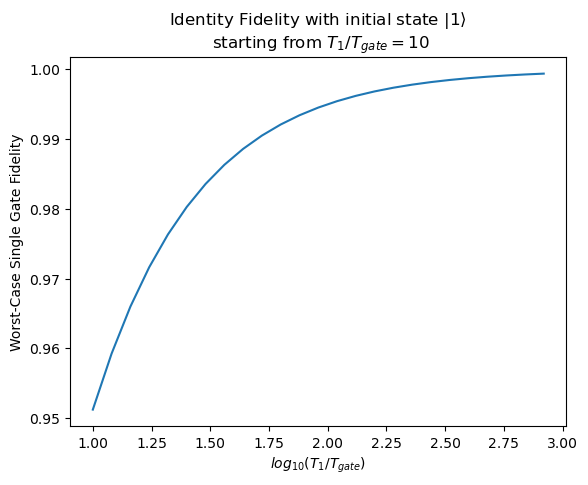

In [4]:
plus = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
T1 = 1
T2 = 1000
f = []
start = time.time()
Tgate=1
T2_list = np.geomspace(Tgate*10, Tgate*1000, num_points, endpoint=False)
for T2 in T2_list:
    qubit = InCoherentQuantumRegister(1,fock_dm(2,1), T1=T2, T2 = 1, Tgate=1, dt = 1/20)
    qubit.setError(dephase = False, amplitude_damp=True)
    qubit.run([[('i',0,None,1)]])
    f.append(fidelity(fock_dm(2,1), qubit.state))
plt.style.use('default')
plt.xlabel('$log_{10}(T_1/T_{gate})$')
plt.ylabel('Worst-Case Single Gate Fidelity')
plt.title('Identity Fidelity with initial state $|1\\rangle$ \n starting from $T_1/T_{gate}=10$')
plt.plot(np.log10(T2_list),f)

Now we create the graphs by loading the data from the folder


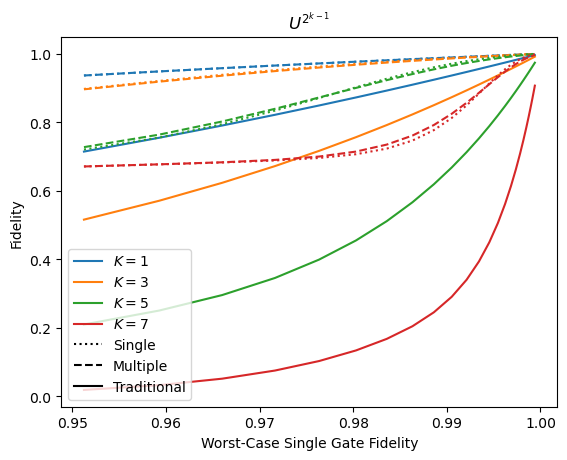

In [5]:
start = 0
end = 25
path = os.getcwd()
folder = os.path.join(path, 'data\\averageing_fidelity\\Kitaev\\SPS_T1')
f_s = np.load(os.path.join(folder,'singleSPSK_fidelity_average.npy'))
f_m = np.load(os.path.join(folder,'multipleSPSK_fidelity_average.npy'))
f_t = np.load(os.path.join(folder,'NoSPSK_fidelity_average.npy'))
plt.xlabel('Worst-Case Single Gate Fidelity')
plt.ylabel('Fidelity')
# plt.style.use('dark_background')
plt.style.use('default')
# x = np.log10(np.geomspace(Tgate*10, Tgate*1000, 25, endpoint=False))[start:end]
ax = plt.gca()
x=f
for k in [0,2,4,6][:]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(x, f_t[:,k], color=color)
    plt.plot(x, f_s[start:end,k], ':', color=color)
    plt.plot(x, f_m[start:end,k], '--', color=color)
    plt.plot(np.NaN, np.NaN, color=color, label='$K='+str(k+1)+'$')

plt.plot(np.NaN, np.NaN,':', color='black', label='Single')
plt.plot(np.NaN, np.NaN,'--', color='black', label='Multiple')
plt.plot(np.NaN, np.NaN, color='black', label='Traditional')
# plt.ylim((0.6,1.01))
plt.title('$U^{2^{k-1}}$')
plt.legend(loc = 'lower left')
plt.show()



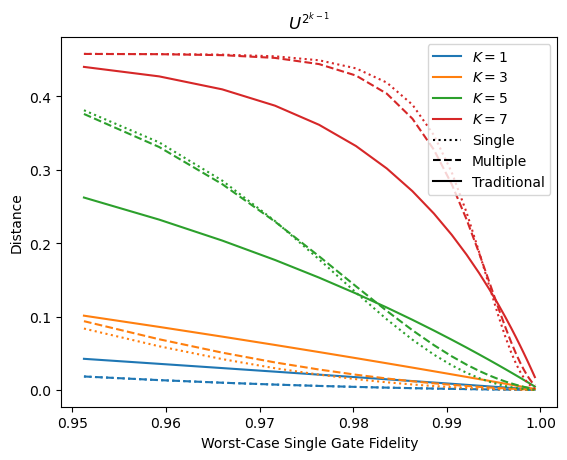

In [6]:

path = os.getcwd()
folder = os.path.join(path, 'data\\averageing_fidelity\\Kitaev\\SPS_T1')
f_s = np.load(os.path.join(folder,'singleSPS_distance_average.npy'))
f_m = np.load(os.path.join(folder,'multipleSPS_distance_average.npy'))
f_t = np.load(os.path.join(folder,'NoSPS_distance_average.npy'))
plt.xlabel('Worst-Case Single Gate Fidelity')
plt.ylabel('Distance')
# plt.style.use('dark_background')
plt.style.use('default')
# x = np.log10(np.geomspace(Tgate*10, Tgate*1000, 25, endpoint=False))
x=f
ax = plt.gca()
for k in [0,2,4,6][:]:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(x, f_t[:,k], color=color)
    plt.plot(x, f_s[:,k],':', color=color)
    plt.plot(x, f_m[:,k],'--', color=color)
    plt.plot(np.NaN, np.NaN, color=color, label='$K='+str(k+1)+'$')
plt.plot(np.NaN, np.NaN,':', color='black', label='Single')
plt.plot(np.NaN, np.NaN,'--', color='black', label='Multiple')
plt.plot(np.NaN, np.NaN, color='black', label='Traditional')
plt.legend()
plt.title('$U^{2^{k-1}}$')
plt.show()

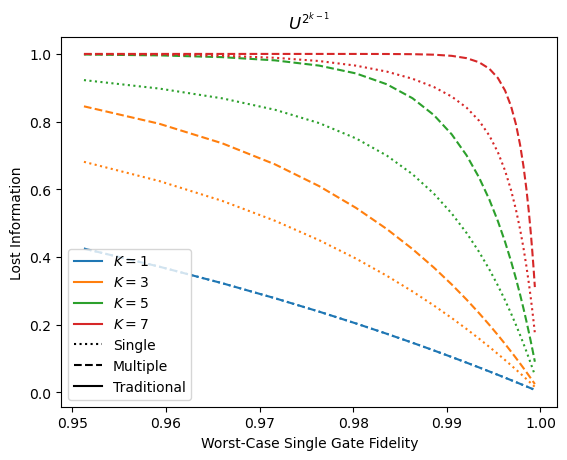

In [7]:
start = 0
end = 25
path = os.getcwd()
folder = os.path.join(path, 'data\\averageing_fidelity\\Kitaev\\SPS_T1')
f_s = np.load(os.path.join(folder,'singleSPS_lost_information_average.npy'))
f_m = np.load(os.path.join(folder,'multipleSPS_lost_information_average.npy'))
f_t = np.load(os.path.join(folder,'NoSPS_lost_information_average.npy'))
plt.xlabel('Worst-Case Single Gate Fidelity')
plt.ylabel('Lost Information')
# plt.style.use('dark_background')
plt.style.use('default')
# x = np.log10(np.geomspace(Tgate*10, Tgate*1000, 25, endpoint=False))[start:end]
x=f
ax = plt.gca()
for k in [0,2,4,6][:]:
    color = next(ax._get_lines.prop_cycler)['color']
    # plt.plot(x, f_t[:,k], color=color)
    plt.plot(x, f_s[start:end,k], ':', color=color)
    plt.plot(x, f_m[start:end,k], '--', color=color)
    plt.plot(np.NaN, np.NaN, color=color, label='$K='+str(k+1)+'$')
plt.plot(np.NaN, np.NaN,':', color='black', label='Single')
plt.plot(np.NaN, np.NaN,'--', color='black', label='Multiple')
plt.plot(np.NaN, np.NaN, color='black', label='Traditional')
plt.legend()
plt.title('$U^{2^{k-1}}$')
plt.show()

# To create the data
### DELETE manually (for safety) the folder 'SPS_T1' from 'data\\averageing_fidelity\\Kitaev' and then run the following code blocks:



In [ ]:
mainSPS(25,10,8,'multipleSPS')

In [ ]:
mainSPS(25,10,8,'NoSPS')

In [ ]:
mainSPS(25,10,8,'singleSPS')